<h1  style="text-align: center" >1. Importing Necessary Libraries</h1><a id = "1"></a>

In [1]:
# работа с данными
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

import warnings 
warnings.filterwarnings("ignore")

# для машинного обучения
import tensorflow as tf
from livelossplot.tf_keras import PlotLossesCallback
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint

<h1  style="text-align: center" >2. Load Data</h1><a id = "2"></a>

<h2>About Dataset</h2>
The dataset contains 2 folders: one with the test data and the other one with train data.
The test-train-split ratio is 0.14, with the test dataset containing 114 images and the train dataset containing 711.
The images have a resolution of 240x240 pixels in RGB color model.
Both the folders contain 3 classes:

1. Adidas
2. Converse
3. Nike

<h2>Inspiration</h2>
This dataset is ideal for performing multiclass classification with deep neural networks like CNNs or simpler machine learning classification models.
You can use Tensorflow, his high-level API keras, Sklearn, PyTorch or other deep/machine learning libraries to building the model from scratch or, as an alternative, fetching pretrained models as well as fine-tuning them.
It is also possible to modify the size of the images or preprocessing them using OpenCV , and check if the accuracy of the model improves.
Remember to upvote if you found the dataset useful :).

<h2>Collection methodology</h2>
The dataset was obtained downloading images from Google images.
The images with a .webp format were transformed into .jpg images. The obtained images were randomly shuffled and resized so that all the images had a resolution of 240x240 pixels.
Then, they were split into train and test datasets and saved.

In [2]:
# импортируем тренировочные данные
brands = ['adidas','nike','converse']

brand = []
img_names = []

df = {'img_names': None, 
     'brand': None}

for i in brands:
    data_folder_tr = Path(f"train\\{i}\\")
    filenames = list(map(lambda x: x.name, data_folder_tr.glob('*.jpg')))
    for j in filenames: 
        brand.append(i)
        img_names.append(j)

df = {'img_names': img_names, 
      'brand': brand}

df_train = pd.DataFrame(df)
df_train.groupby('brand')['img_names'].agg('count')

brand
adidas      237
converse    237
nike        237
Name: img_names, dtype: int64

In [3]:
# импортируем тестовые данные
brands = ['adidas','nike','converse']

brand = []
img_names = []

df = {'img_names': None, 
     'brand': None}

for i in brands:
    data_folder_test = Path(f"test\\{i}\\")
    filenames = list(map(lambda x: x.name, data_folder_test.glob('*.jpg')))
    for j in filenames: 
        brand.append(i)
        img_names.append(j)

df = {'img_names': img_names, 
      'brand': brand}

df_test = pd.DataFrame(df)
df_test.groupby('brand')['img_names'].agg('count')

brand
adidas      38
converse    38
nike        38
Name: img_names, dtype: int64

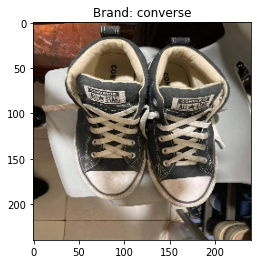

In [4]:
# проверяем, что метка стоит к правильной картинке
row = df_train.iloc[np.random.randint(len(df_train))][0]
br = df_train.iloc[np.random.randint(len(df_train))][1]
data_folder = Path(f"train\\{br}\\")

img = plt.imread(str(data_folder / row))
plt.imshow(img)
plt.title(f"Brand: {br}")
plt.show() 

<h1  style="text-align: center" >3. Data Preprocessing</h1><a id = "3"></a>

In [5]:
#генерируем данные с использованием аугментации
image_gen_train = ImageDataGenerator(rescale=1./255,
                              rotation_range=45,
                              width_shift_range=0.2,
                              height_shift_range=0.2,
                              zoom_range=0.2,
                              fill_mode='nearest')

image_gen_test = ImageDataGenerator(rescale=1./255,
                              rotation_range=30,
                              width_shift_range=0.1,
                              height_shift_range=0.2,
                              zoom_range=0.15,
                              fill_mode='nearest')

BATCH_SIZE = 32
IMAGE_SIZE = 224

train_dir = Path(f"train\\")
test_dir = Path(f"test\\")

train_generator = image_gen_train.flow_from_directory(directory = train_dir,
                                               class_mode='sparse',
                                               batch_size=BATCH_SIZE,
                                               target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                               shuffle=True)

test_generator = image_gen_test.flow_from_directory(directory=test_dir,
                                             class_mode='sparse',
                                             batch_size=BATCH_SIZE,
                                             target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                             shuffle=True)


Found 711 images belonging to 3 classes.
Found 114 images belonging to 3 classes.


In [6]:
# генерируем выборку
train_data, train_label = next(train_generator)
test_data, test_label = next(test_generator)

In [7]:
def show_shoes(images, labels, predicted_labels=None):
    """
    Функция для представления выборки (из 16 элементов) в формате: картинка - реальный бренд - предсказанный бренд (если есть).
    images - картинки
    labels - реальные классы
    predicted_labels - предсказанные классы
    
    """
    names = {0: "Adidas", 1:"Converse" ,2: "Nike"}
    plt.figure(figsize=(15,15))
    for i in range(16):
        plt.subplot(4,4, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.gray)
        if predicted_labels is not None:
            title_obj = plt.title(f"Real: {names[labels[i]]}. Pred: {names[predicted_labels[i]]}")
            if labels[i] != predicted_labels[i]:
                plt.setp(title_obj, color='r')
        else:
            plt.title(f"Real label: {names[labels[i]]}")

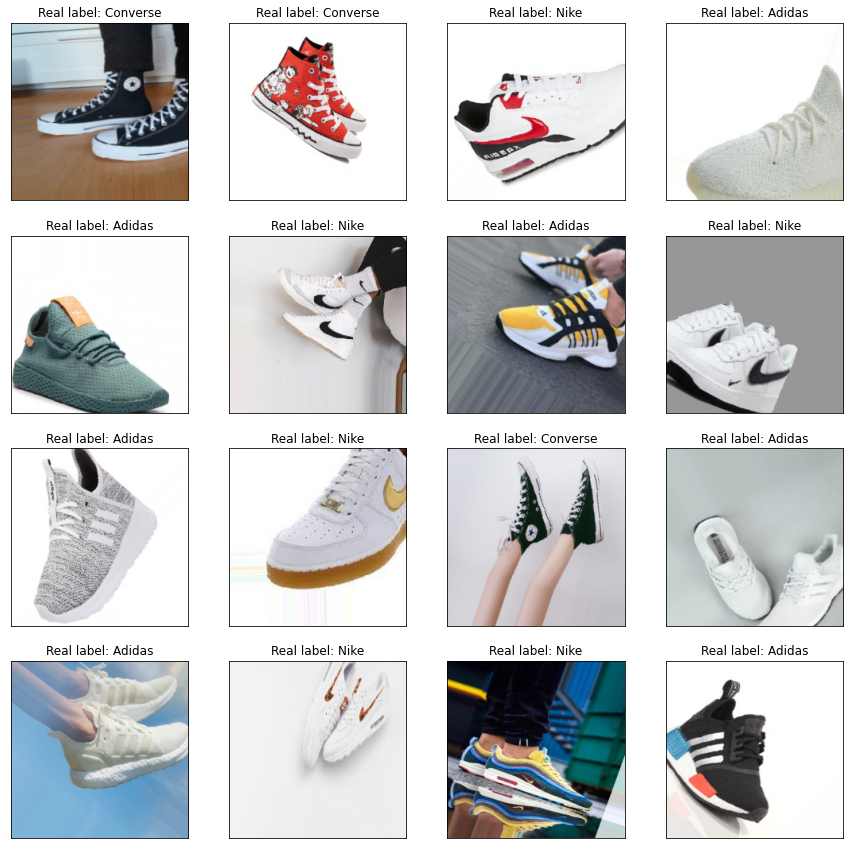

In [8]:
# картинки кроссовок с реальной меткой класса
show_shoes(images=train_data, labels=train_label)

<h1  style="text-align: center" >4. Models</h1><a id = "3"></a>

In [9]:
train_data.shape

(32, 224, 224, 3)

In [10]:
# делаем файл с сохранением наилучших весов
cpt_filename = "best_checkpoint_.h5"
check = ModelCheckpoint(cpt_filename, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [11]:
# за основу используем готовую модель ResNet50V2
base_model = tf.keras.applications.ResNet50V2(include_top = False)
base_model.trainable = False
print(len(base_model.layers))

190


In [12]:
INPUT_SHAPE = (224, 224, 3)

base_model.trainable = False

Model = tf.keras.models.Sequential([tf.keras.layers.Input(shape = INPUT_SHAPE),
                                    base_model,
                                    tf.keras.layers.GlobalAveragePooling2D(), 
                                    tf.keras.layers.Flatten(),
                                     tf.keras.layers.Dense(650, activation = tf.nn.softplus),
                                     tf.keras.layers.Dropout(0.1),
                                    tf.keras.layers.BatchNormalization(),
                                     tf.keras.layers.Dense(800, activation = tf.nn.relu),
                                     tf.keras.layers.Dropout(0.2),
                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.Dense(400, activation = tf.nn.softplus),
                                    tf.keras.layers.Dropout(0.2),
                                    tf.keras.layers.Dense(3, activation='softmax')
                                   ])

Model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.005),
             loss = "sparse_categorical_crossentropy",
             metrics = ['accuracy'])

Model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, None, None, 2048)  23564800  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 650)               1331850   
                                                                 
 dropout (Dropout)           (None, 650)               0         
                                                                 
 batch_normalization (BatchN  (None, 650)              2600      
 ormalization)                                          

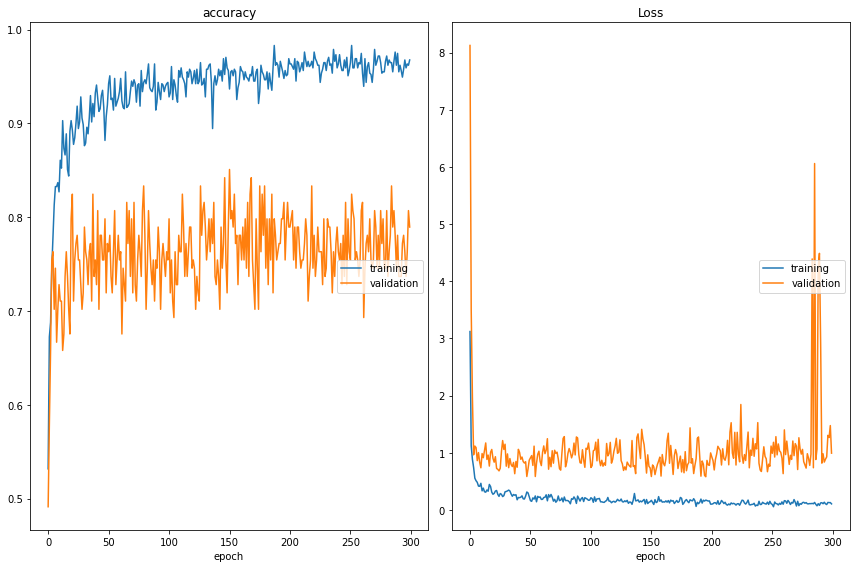

accuracy
	training         	 (min:    0.532, max:    0.983, cur:    0.968)
	validation       	 (min:    0.491, max:    0.851, cur:    0.789)
Loss
	training         	 (min:    0.057, max:    3.121, cur:    0.107)
	validation       	 (min:    0.582, max:    8.125, cur:    0.994)

Epoch 300: val_accuracy did not improve from 0.85088
23/23 [==============================] - 25s 1s/step - loss: 0.1069 - accuracy: 0.9677 - val_loss: 0.9938 - val_accuracy: 0.7895


In [13]:
#обучаем модель
history = Model.fit(train_generator, epochs = 300, validation_data=(test_generator), 
         batch_size = 10, callbacks=[PlotLossesCallback(), check])

In [14]:
#итоговый accuracy и loss тестовой выборки
model = tf.keras.models.load_model("best_checkpoint_.h5")

loss, acc = model.evaluate(test_generator)
print(f'Val_accuracy: {acc*100}. Loss: {loss}')

4/4 [==============================] - 5s 805ms/step - loss: 0.6976 - accuracy: 0.7895
Val_accuracy: 78.94737124443054. Loss: 0.6975842714309692


1/1 [==============================] - 2s 2s/step


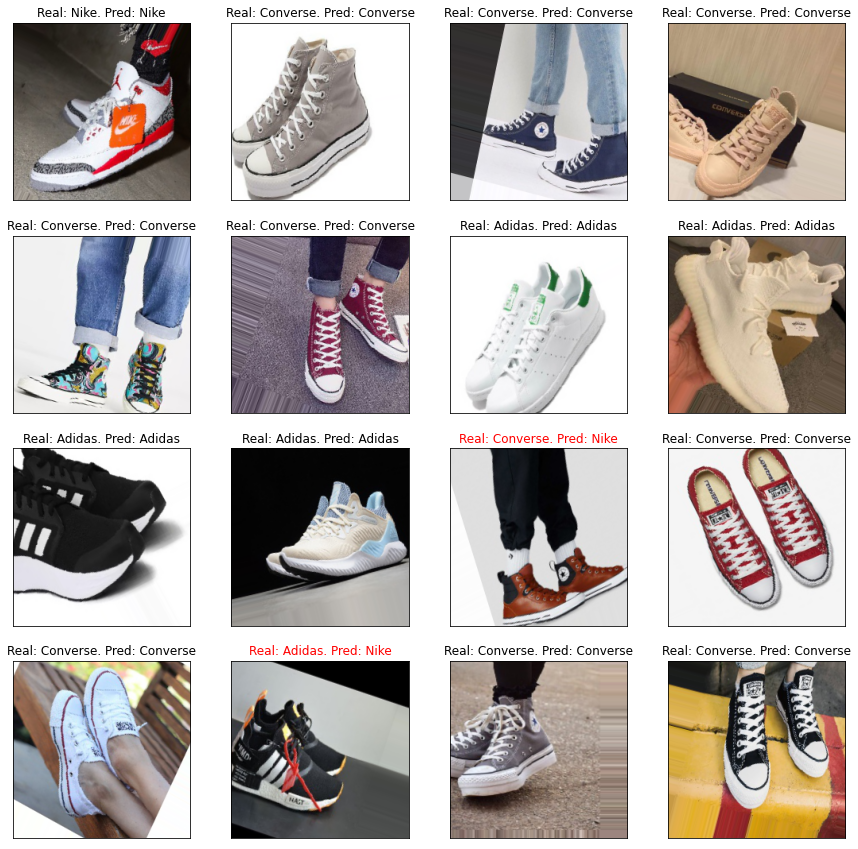

In [17]:
#теперь посмотрим на предсказание меток и реальный класс
val_data, val_label = next(test_generator)
predicted = model.predict(val_data)
predicted_label = []
for i in range(len(predicted)):
    predicted_label.append(np.argmax(predicted[i]))

show_shoes(val_data, labels=val_label, predicted_labels=predicted_label)